# Car Model Classification

## 4 Models
- Accura - RDX
- Honda - Civic
- Honda - CRV
- Toyota - RAV4

# Import Modules

In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop
from tensorflow.keras.layers.experimental.preprocessing import Rescaling


# Check Number of GPUs Available

In [189]:
print("Num GPUs Available  : ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available  :  1


In [190]:
print("TF version:", tf.__version__)
print("Keras verion:", keras.__version__)

TF version: 2.4.0
Keras verion: 2.4.0


# Data Loading and Preprocessing
- Generates batches of tensor image data with data augmentation

In [192]:
# Data loading

BATCH_SIZE = 32
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = (128, 128, 3)

NUMBER_OF_CLASSES = 4
TRAIN_DIR = 'data/cars/train'
TEST_DIR = 'data/cars/test'
SEED = 11223344

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    brightness_range=(0.6, 1.0),
    channel_shift_range=0,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    class_mode='sparse',
    batch_size=BATCH_SIZE, 
    target_size=IMAGE_SIZE,
    subset="training",
    seed=SEED
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    class_mode='sparse',
    batch_size=BATCH_SIZE, 
    target_size=IMAGE_SIZE,
    subset="validation",
    seed=SEED
)


Found 2263 images belonging to 4 classes.
Found 563 images belonging to 4 classes.


In [193]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_generator = train_datagen.flow_from_directory(
    TEST_DIR,
    class_mode='sparse',
    batch_size=BATCH_SIZE, 
    target_size=IMAGE_SIZE,
    seed=SEED,
)

Found 587 images belonging to 4 classes.


# Visualize Dataset

In [41]:
# Helper Methods to visualize images

def get_label_map(gen):
    label_map = gen.class_indices  # {'Accura - RDX': 0, 'Honda - Civic': 1 ...etc}
    label_map = dict((v, k) for k,v in label_map.items()) # Flip k, v
    
    return label_map


def show_imgs(gen):
    images_len = len(gen.next()[0])

    n = gen.next()
    images = n[0]
    labels = n[1]
    label_map = get_label_map(gen)
    
    fig = plt.figure(figsize=(16, 16))

    for i, img in enumerate(images):
        ax = fig.add_subplot(6, 6, i+1)
        plt.imshow(img)
        plt.title(label_map[labels[i]])
        plt.axis("off")
    

### Models To Classify

In [197]:
train_generator.class_indices

{'Acura - RDX': 0, 'Honda - CRV': 1, 'Honda - Civic': 2, 'Toyota - RAV4': 3}

### Visualize Train Dataset

In [198]:
show_imgs(train_generator)

### Visualize Test Dataset

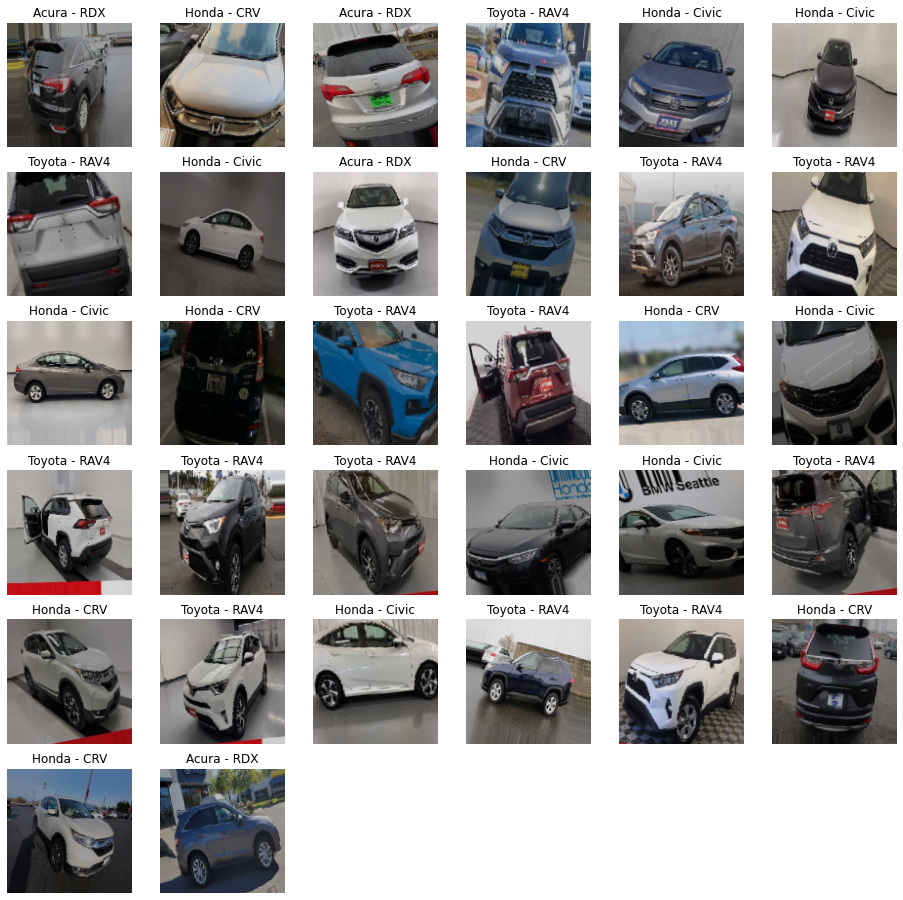

In [199]:
show_imgs(test_generator)

# Deep Learning
- Since the dataset is small (~2700) it is better to use transfer learning for this task
- Im Using a VGG16 model pre-trained on imagenet dataset
- Then Im adding a GlobalAveragePooling2D layer, a few Dense layers and 50% Dropout for regularization

In [200]:
def create_model_vgg(input_shape=(64, 64, 3), num_classes= 10):
    # Remove fully connected layer at top (include_top=False)
    # Dont load any pre-trained weights (weights=None)
    print(input_shape)
    base_model = keras.applications.vgg16.VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape)

    # Use keras functional Api to add input and output layers for our task
    input = tf.keras.Input(shape=input_shape)
    base_model = base_model(input)

    # Add our own layers 
    x = keras.layers.GlobalAveragePooling2D()(base_model)
    x = keras.layers.Dense(64, activation="relu")(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    
    output = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.models.Model(input, output)

    return model


In [201]:
# Function to compile a given model

def compile_model(model, lr):
    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=lr),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
    return model

In [202]:
# Function to lock or unlock layers

def lock_base_model_trainable(model, isTrainable):
    base_model_layers = model.layers[1].layers

    for layer in base_model_layers:
        layer.trainable = isTrainable

    return model

In [203]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=10,
    restore_best_weights=True
)

# Create Model

In [220]:
model = create_model_vgg(INPUT_SHAPE, NUMBER_OF_CLASSES)

(128, 128, 3)


In [221]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 132 

# Train
### 1) Freeze weights of the pre-trained model
### 2) Compile model
### 3) Train for few epochs

In [222]:
# Freeze base_model
model = lock_base_model_trainable(model, isTrainable=False)

# Now compile model with high learning rate for few epoches
model = compile_model(model, lr=1e-3)

# Train for few epochs
# This will only train the extra layers we added to the top of the model since base_layers weigths are locked
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    callbacks=[early_stopping],
    epochs=10
)

Epoch 1/10
71/71 [==============================] - 22s 293ms/step - loss: 1.4753 - accuracy: 0.2987 - val_loss: 1.3404 - val_accuracy: 0.3712
Epoch 2/10
71/71 [==============================] - 20s 287ms/step - loss: 1.3303 - accuracy: 0.3608 - val_loss: 1.3005 - val_accuracy: 0.4156
Epoch 3/10
71/71 [==============================] - 20s 288ms/step - loss: 1.2803 - accuracy: 0.4029 - val_loss: 1.2428 - val_accuracy: 0.4973
Epoch 4/10
71/71 [==============================] - 20s 283ms/step - loss: 1.2594 - accuracy: 0.4272 - val_loss: 1.2131 - val_accuracy: 0.4583
Epoch 5/10
71/71 [==============================] - 20s 288ms/step - loss: 1.2271 - accuracy: 0.4530 - val_loss: 1.1967 - val_accuracy: 0.4796
Epoch 6/10
71/71 [==============================] - 21s 293ms/step - loss: 1.1883 - accuracy: 0.4907 - val_loss: 1.1668 - val_accuracy: 0.5204
Epoch 7/10
71/71 [==============================] - 21s 293ms/step - loss: 1.1504 - accuracy: 0.4940 - val_loss: 1.1703 - val_accuracy: 0.4920

# Train Again
### 1) Un-Freeze weights of the  pre-trained model
### 2) Compile Model again
### 3) Train for few epochs with low learing rate

### Use a low learning rate to avaoid damaging the pre-trained weights

In [223]:
# Un-Freeze base_model
model = lock_base_model_trainable(model, isTrainable=True)

# Compile model again with low learning rate
model = compile_model(model, lr=1e-4)

# Train model
# We set early_stopping with monitor="val_loss" & mode="min"
# So training will stop when it hits the lowest val_loss
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    callbacks=[early_stopping],
    epochs=100
)


Epoch 1/100
71/71 [==============================] - 24s 317ms/step - loss: 2.4649 - accuracy: 0.2969 - val_loss: 1.3727 - val_accuracy: 0.3179
Epoch 2/100
71/71 [==============================] - 22s 304ms/step - loss: 1.4088 - accuracy: 0.2804 - val_loss: 1.4738 - val_accuracy: 0.3037
Epoch 3/100
71/71 [==============================] - 22s 304ms/step - loss: 1.4035 - accuracy: 0.3103 - val_loss: 1.3645 - val_accuracy: 0.3091
Epoch 4/100
71/71 [==============================] - 22s 305ms/step - loss: 1.3588 - accuracy: 0.3535 - val_loss: 1.3299 - val_accuracy: 0.3037
Epoch 5/100
71/71 [==============================] - 22s 312ms/step - loss: 1.2902 - accuracy: 0.4209 - val_loss: 1.1780 - val_accuracy: 0.4689
Epoch 6/100
71/71 [==============================] - 22s 306ms/step - loss: 1.1872 - accuracy: 0.4764 - val_loss: 1.2221 - val_accuracy: 0.4227
Epoch 7/100
71/71 [==============================] - 22s 306ms/step - loss: 1.1145 - accuracy: 0.5275 - val_loss: 1.0563 - val_accuracy:

# Visualize Results from Training

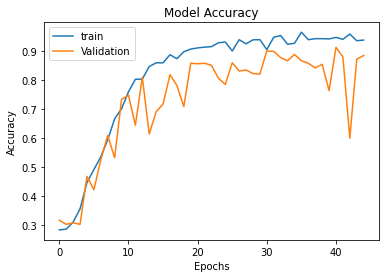

In [224]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'Validation'])
plt.show()

In [225]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'Validation'])
plt.show()

In [226]:
# validation_results = model.evaluate(validation_generator, batch_size=BATCH_SIZE)

# Evaluate Model with Test Dataset
### Don't use the Test Dataset until the model is ready
### Use the Validation Dataset to fine-tune the model during the training phase

In [229]:
eval_results = model.evaluate(test_generator, batch_size=BATCH_SIZE)

19/19 [==============================] - 5s 234ms/step - loss: 0.2851 - accuracy: 0.9131


# Predictions

In [230]:
pred = model.predict(test_generator)

df = pd.DataFrame(pred, columns = list(test_generator.class_indices.keys()))

print(df)


      Acura - RDX   Honda - CRV  Honda - Civic  Toyota - RAV4
0    8.453938e-02  6.453071e-01   1.685162e-01   1.016372e-01
1    5.257515e-03  4.260468e-03   9.895509e-01   9.311191e-04
2    9.932109e-01  2.547419e-03   3.792750e-03   4.490203e-04
3    1.139351e-01  7.124087e-01   1.055632e-01   6.809296e-02
4    2.601996e-03  9.928618e-01   4.216332e-03   3.198505e-04
..            ...           ...            ...            ...
582  1.953908e-35  1.715456e-26   1.000000e+00   1.685588e-36
583  9.822885e-08  9.999995e-01   3.134032e-07   1.377338e-09
584  6.358714e-04  6.576590e-04   7.297182e-05   9.986334e-01
585  1.842026e-01  5.571944e-01   1.857056e-01   7.289742e-02
586  1.000000e+00  8.791882e-10   1.590543e-10   6.911164e-11

[587 rows x 4 columns]


# Predict More Images
- This Dataset contains images from Trucars.com and from other 3rd party sites
- Predict front, side, back views of cars
- This also contains some images our model has not trained on
- Example: Car interior images, Similar models from same company, Models from different company, Images Used for Advertising

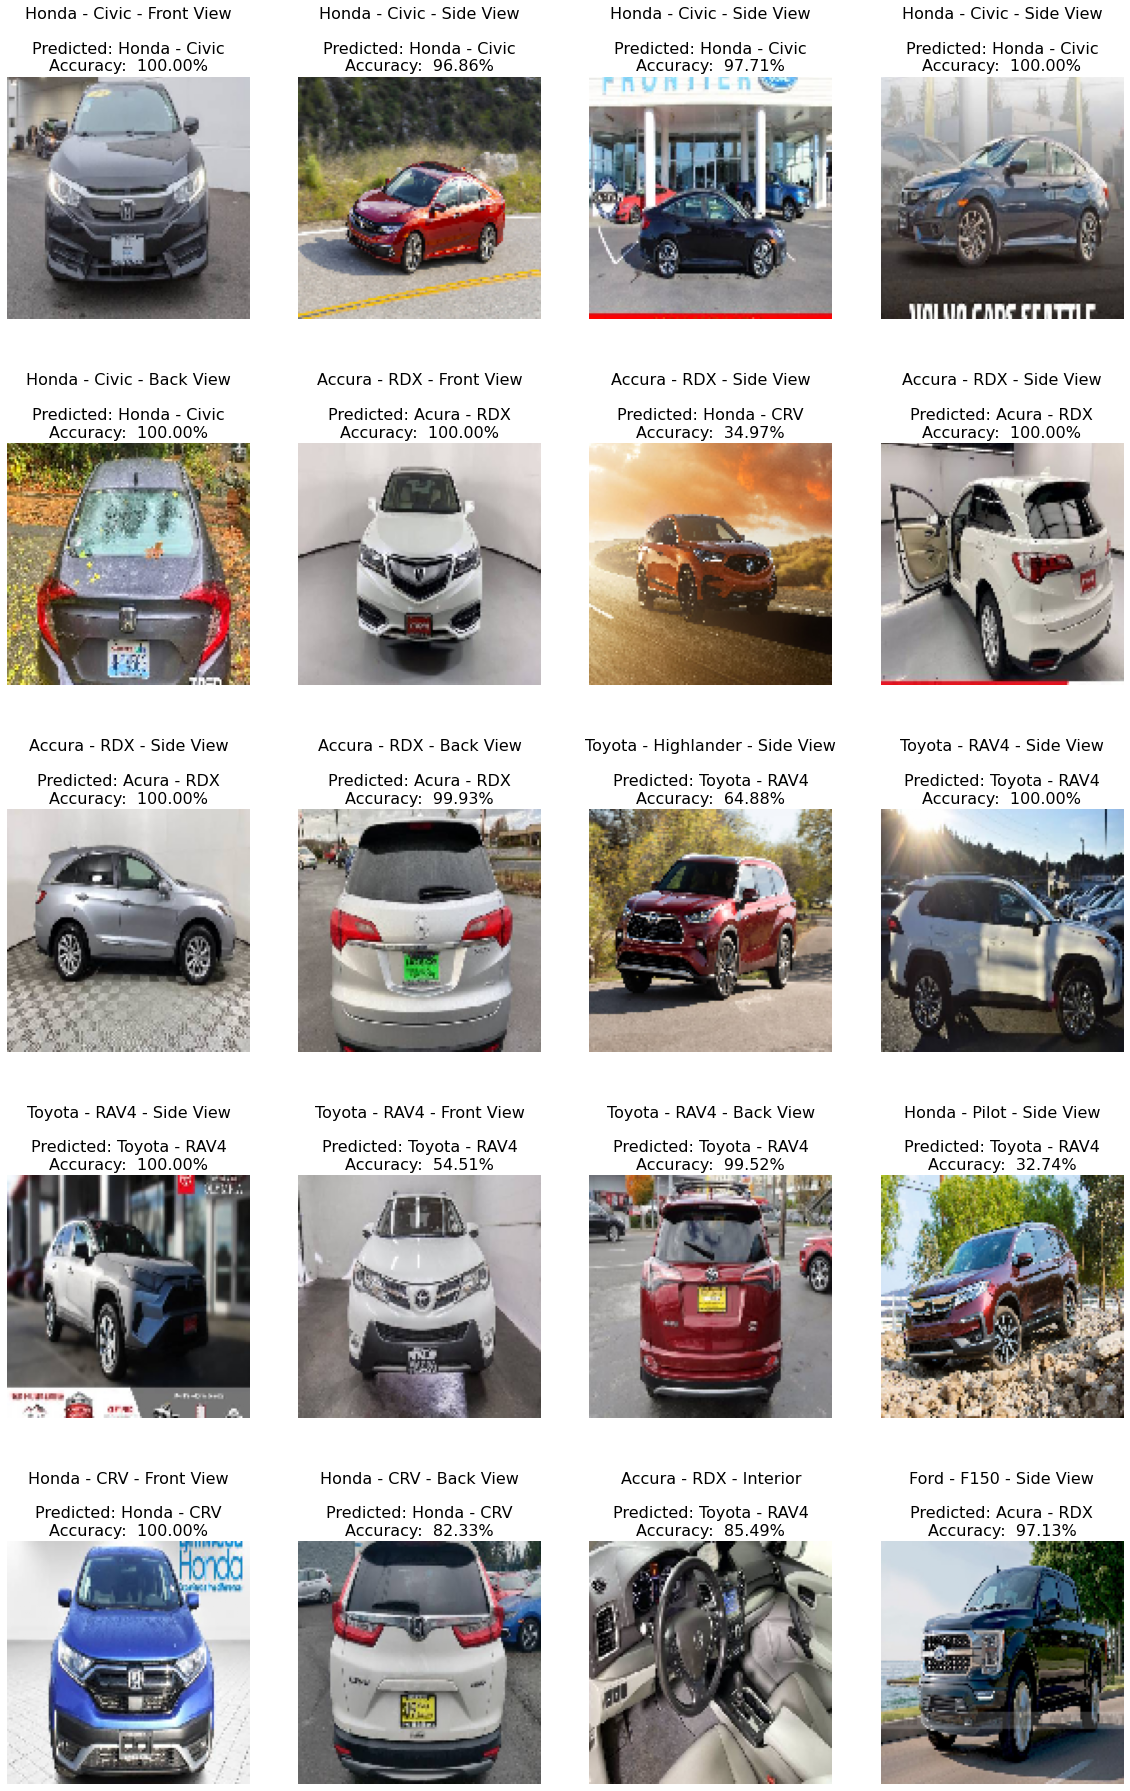

In [231]:
label_map = get_label_map(test_generator)

def get_label_from_pred(pred, label_map):
    arg_max = np.argmax(pred)
    accuracy = pred[arg_max]
    return accuracy, label_map[arg_max]


def load_image(img_loc, image_size):
    image = keras.preprocessing.image.load_img(img_loc, target_size=image_size)
    image = keras.preprocessing.image.img_to_array(image)
    return image


def show_test_imgs(model, test_dataset, label_map):
    
    fig = plt.figure(figsize=(20, 20))
    
    for i, t in enumerate(test_dataset):
        car = t['car']
        view = t['view']
        image_loc = t['image_loc']
        
        # Load image
        img = load_image(image_loc, IMAGE_SIZE)/255
        
        # Plot image
        ax = fig.add_subplot(10, 4, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.subplots_adjust(top=2.5, bottom=0)
        
        # Get Prediction for image
        img = np.expand_dims(img, axis=0)
        pred = model.predict(img)[0]
        
        # Get car label for prediction
        accuracy, pred_label = get_label_from_pred(pred, label_map)
        
        # Add Titlte to plot
        plt.title(f"{car} - {view}\n\nPredicted: {pred_label}\nAccuracy: {accuracy*100 : .2F}%", fontsize=16)
        
test_dataset = [
    {'car': 'Honda - Civic', 'view': 'Front View', 'image_loc': 'data/cars/views/civic-f.jpg'},
    {'car': 'Honda - Civic', 'view': 'Side View', 'image_loc': 'data/cars/views/civic-fs.jpg'},
    {'car': 'Honda - Civic', 'view': 'Side View', 'image_loc': 'data/cars/views/civic-s-3.jpg'},
    {'car': 'Honda - Civic', 'view': 'Side View', 'image_loc': 'data/cars/views/civic-s-2.jpg'},
    {'car': 'Honda - Civic', 'view': 'Back View', 'image_loc': 'data/cars/views/civic-b.jpg'},
    
    {'car': 'Accura - RDX', 'view': 'Front View', 'image_loc': 'data/cars/views/accura-f.jpg'},
    {'car': 'Accura - RDX', 'view': 'Side View', 'image_loc': 'data/cars/views/accura-s-3.jpg'},
    {'car': 'Accura - RDX', 'view': 'Side View', 'image_loc': 'data/cars/views/accura-bs.jpg'},
    {'car': 'Accura - RDX', 'view': 'Side View', 'image_loc': 'data/cars/views/accura-s-2.jpg'},
    {'car': 'Accura - RDX', 'view': 'Back View', 'image_loc': 'data/cars/views/accura-b.jpg'},
    
    {'car': 'Toyota - Highlander', 'view': 'Side View', 'image_loc': 'data/cars/views/highlander-s-1.jpg'},
    {'car': 'Toyota - RAV4', 'view': 'Side View', 'image_loc': 'data/cars/views/rav4-s-2.jpg'},
    {'car': 'Toyota - RAV4', 'view': 'Side View', 'image_loc': 'data/cars/views/rav4-s-3.jpg'},
    {'car': 'Toyota - RAV4', 'view': 'Front View', 'image_loc': 'data/cars/views/rav4-f-1.jpg'},
    {'car': 'Toyota - RAV4', 'view': 'Back View', 'image_loc': 'data/cars/views/rav4-b-1.jpg'},
    
    {'car': 'Honda - Pilot', 'view': 'Side View', 'image_loc': 'data/cars/views/pilot-s-1.jpg'},
    {'car': 'Honda - CRV', 'view': 'Front View', 'image_loc': 'data/cars/views/crv-f-1.jpg'},
    {'car': 'Honda - CRV', 'view': 'Back View', 'image_loc': 'data/cars/views/crv-b-1.jpg'},
    
    {'car': 'Accura - RDX', 'view': 'Interior', 'image_loc': 'data/cars/views/random-1.jpg'},
    {'car': 'Ford - F150', 'view': 'Side View', 'image_loc': 'data/cars/views/random-2-ford-2021.jpg'},
]

show_test_imgs(model, test_dataset, label_map)


# Save Model

In [232]:
# Save Model
model.save("saved_models/car_classification_model.h5")